# Проект Маркетинг

## Описание проекта

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи. Для оптимизации процессов надо выделить пользователей, которые готовы совершить покупку в ближайшее время.

## Цель проекта
Предсказать вероятность покупки в течении 90 дней

### Описание данных

Датафрейм `apparel-purchases`

Данные о покупках клиентов по дням и по товарам. В каждой записи покупка определенного товара, его цена, количество штук.

- `client_id` — идентификатор клиента

- `quantity` — количество единиц товара

- `price` — цена товара

- `category_ids` — идентификаторы категорий

- `date` — дата покупки

- `message_id` — идентификатор сообщения из рассылки

Датафрейм `apparel-messages`

Рассылки, которые были отправлены клиентам из таблицы покупок.

- `bulk_campaign_id` — идентификатор рассылки

- `client_id` — идентификатор клиента

- `message_id` — идентификатор сообщения

- `event` — действие с сообщением (отправлено, открыто, покупка…)

- `channel` — канал рассылки

- `date` — дата действия

- `created_at` — дата-время полностью

Датафрейм `target`

- `client_id` — идентификатор клиента

- `target` — клиент совершил покупку в целевом периоде

In [1]:
# Загрузим необходимые библиотеки
!pip install phik -q
!pip install shap -q
!pip install pipreqs  -q

In [2]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import phik
import time
import os

from datetime import timedelta

# Для визуализации данных
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# Для Машинного обучения
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from catboost import Pool, CatBoostClassifier, cv

# Загружаем классы для преобразования данных
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)

# Метрики
from sklearn.metrics import roc_auc_score, confusion_matrix

# Для пайплайна
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Переменные
RANDOM_STATE = 42
TEST_SIZE =0.25

# Отключение предупреждений
import warnings
warnings.filterwarnings("ignore")

# Отображение всех столбцов
pd.set_option('display.max_columns', None)

# Формат вывода без экспоненты
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
#Загрузим необходимый датафрейм apparel-purchases
df_purchases = pd.read_csv('apparel-purchases.csv')

In [4]:
#Выведем первые строки датафрейма df_purchases
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.00,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.00,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [5]:
#Изучим общую информацию об датафрейме df_purchases
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [6]:
#Загрузим необходимый датафрейм apparel-target_binary
df_target = pd.read_csv('apparel-target_binary.csv')

In [7]:
#Выведем первые строки датафрейма df_target
df_target.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [8]:
#Изучим общую информацию об датафрейме df_target
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [9]:
#Загрузим необходимый датафрейм apparel-messages
df_messages = pd.read_csv('apparel-messages.csv')

In [10]:
#Выведем первые строки датафрейма df_messages 
df_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [11]:
#Изучим общую информацию об датафрейме df_messages
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


**Вывод:**

Датафреймы загружены.

### Предобработка и исследовательский анализ данных

In [12]:
# Функция для построения графиков для качественных данных
def print_barh (df_column):
# Построение горизонтальной диаграммы
    ax = df_column.value_counts(ascending=True).plot(
    kind='barh',
    figsize=(10, 6)
)

# Добавление значений рядом со столбцами
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width}',
                    (width, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center',
                    xytext=(5, 0),
                    textcoords='offset points')

In [13]:
# функция для построения boxplot
def boxplot (df, col, title, xlabel):
    fig, ax = plt.subplots(figsize = (17,5))
    ax = df[[col]].boxplot(vert = False, ax =ax)
    ax.set_title(title)
    ax.set_xlabel(xlabel, fontsize = 12);

#### Датафрейм df_purchases

In [14]:
df_purchases.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,1999.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,2499.00,"['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,6499.00,"['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,4999.00,"['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,4999.00,"['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


In [15]:
df_purchases.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   client_id     202208 non-null  int64  
 1   quantity      202208 non-null  int64  
 2   price         202208 non-null  float64
 3   category_ids  202208 non-null  object 
 4   date          202208 non-null  object 
 5   message_id    202208 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 9.3+ MB


In [16]:
df_purchases['date'] = pd.to_datetime(df_purchases['date']).dt.floor('D')

In [17]:
df_purchases['price'] = df_purchases['price'].astype(int)

In [18]:
# Выведем информацию о наличии пропусков
df_purchases.isna().sum()

client_id       0
quantity        0
price           0
category_ids    0
date            0
message_id      0
dtype: int64

In [19]:
#Проверим наличие явных дубликатов
df_purchases.duplicated().sum()

73020

Возможно человек повторно перешел по ссылке в рекламных рассылках и повторно заказал товар.\
Оставим дубликаты

In [20]:
df_purchases['quantity'].value_counts()

1     201323
2        751
3         94
4         12
6          5
10         4
5          3
15         3
20         3
9          2
25         2
30         2
7          1
8          1
13         1
18         1
Name: quantity, dtype: int64

In [21]:
df_purchases['price'].describe()

count   202208.00
mean      1193.30
std       1342.25
min          1.00
25%        352.00
50%        987.00
75%       1699.00
max      85499.00
Name: price, dtype: float64

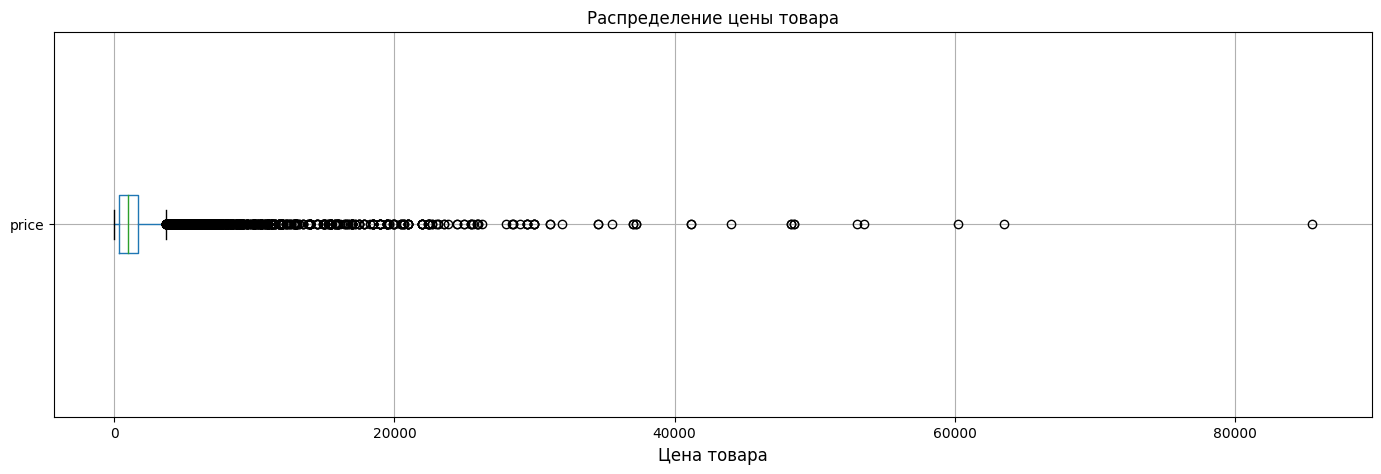

In [22]:
boxplot(df_purchases,
        'price', 
        'Распределение цены товара',
        'Цена товара'
       )

In [23]:
df_purchases['price'].quantile(0.95)

3199.0

In [24]:
# Выводим строки где 'category_ids' равен '[]'
null_category_rows = df_purchases[df_purchases['category_ids'] == '[]']
print(null_category_rows)

                  client_id  quantity  price category_ids       date  \
22153   1515915625558323436         1      1           [] 2022-07-09   
22154   1515915625558323436         1      1           [] 2022-07-09   
49215   1515915625474537721         1      7           [] 2022-11-12   
53223   1515915625720375281         1      5           [] 2022-11-13   
59056   1515915625867975448         1      7           [] 2022-11-16   
...                     ...       ...    ...          ...        ...   
201990  1515915625641742458         1      7           [] 2024-02-16   
202068  1515915625955716904         1      7           [] 2024-02-16   
202069  1515915625955716904         1      7           [] 2024-02-16   
202144  1515915626007712189         1     12           [] 2024-02-16   
202145  1515915626007712189         1     12           [] 2024-02-16   

                                     message_id  
22153    1515915625487742246-5335-62c7d2d1281c7  
22154    1515915625487742246-5335-6

In [25]:
df_purchases = df_purchases.query('category_ids != "[]"')

В большинстве систем подобного рода конечный элемент пути является целевой категорией, а все предыдущие это путь к ней (родители).\
Оставим только последнюю категорию в `category_ids`

In [26]:
# Преобразуем строки в списки
df_purchases['category_ids'] = df_purchases['category_ids'].apply(lambda x: eval(x) if isinstance(x, str) else x)

In [27]:
# Берем последнюю категорию
df_purchases['category'] = df_purchases['category_ids'].str[-1]
print(f"Количество уникальных категорий: {df_purchases['category'].nunique()}")

Количество уникальных категорий: 842


In [28]:
df_purchases['category'].value_counts()

431     8626
420     6989
432     6821
421     4936
441     4905
        ... 
5529       1
1089       1
1727       1
1600       1
751        1
Name: category, Length: 842, dtype: int64

In [29]:
print(f"Количество уникальных клиентов: {df_purchases['client_id'].nunique()}")

Количество уникальных клиентов: 49848


In [30]:
df_grouped = df_purchases.groupby(['message_id', 'client_id','category', 'date'])[['quantity', 'price']].sum().reset_index()
df_grouped.head(10)

,message_id,client_id,category,date,quantity,price
0,1515915625468060902-4617-6290657dac196,1515915625468060902,1599,2022-05-27,1,1299
1,1515915625468060902-4617-6290657dac196,1515915625468060902,420,2022-05-27,2,3998
2,1515915625468060902-4617-6290657dac196,1515915625468060902,422,2022-05-27,1,299
3,1515915625468060902-4617-6290657dac196,1515915625468060902,432,2022-05-27,1,999
4,1515915625468060902-4617-6290657dac196,1515915625468060902,458,2022-05-27,2,398
5,1515915625468061003-9148-63b54b04855a4,1515915625468061003,615,2023-01-04,7,16235
6,1515915625468061099-4439-62834141aa538,1515915625468061099,424,2022-05-17,1,299
7,1515915625468061100-14623-65c5c55eeb9e0,1515915625468061100,5717,2024-02-10,2,2098
8,1515915625468061170-11144-641ad2cda77a2,1515915625468061170,441,2023-03-26,2,5398
9,1515915625468061170-11208-6423f082d2fcb,1515915625468061170,420,2023-03-29,12,25192


In [31]:
# Добавим признаков из даты
df_grouped['year'] = df_grouped['date'].dt.year
df_grouped['month'] = df_grouped['date'].dt.month
df_grouped['day'] = df_grouped['date'].dt.day
df_grouped['day_of_week']= df_grouped['date'].dt.dayofweek

In [32]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93646 entries, 0 to 93645
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   message_id   93646 non-null  object        
 1   client_id    93646 non-null  int64         
 2   category     93646 non-null  object        
 3   date         93646 non-null  datetime64[ns]
 4   quantity     93646 non-null  int64         
 5   price        93646 non-null  int32         
 6   year         93646 non-null  int64         
 7   month        93646 non-null  int64         
 8   day          93646 non-null  int64         
 9   day_of_week  93646 non-null  int64         
dtypes: datetime64[ns](1), int32(1), int64(6), object(2)
memory usage: 6.8+ MB


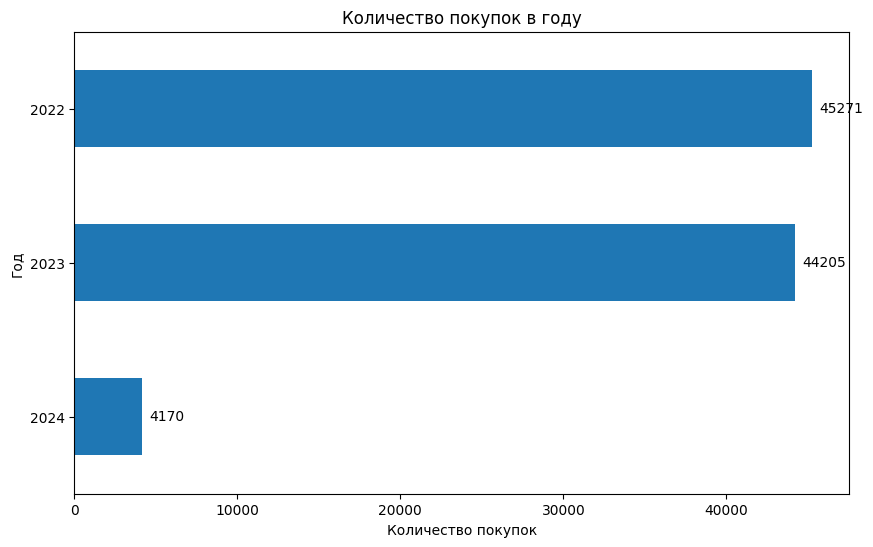

In [33]:
print_barh(df_grouped['year'])
plt.title('Количество покупок в году')
plt.xlabel('Количество покупок')
plt.ylabel('Год')
plt.show()

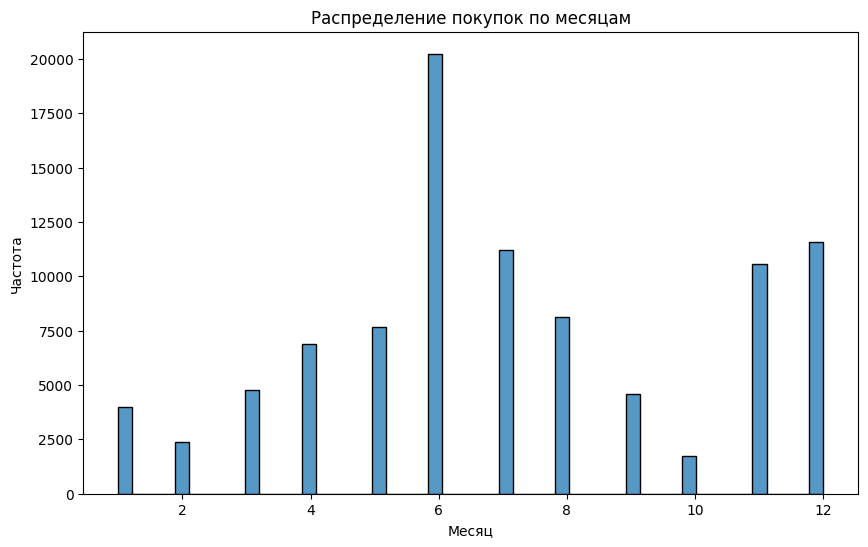

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(df_grouped['month'])
plt.title('Распределение покупок по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Частота')
plt.show()

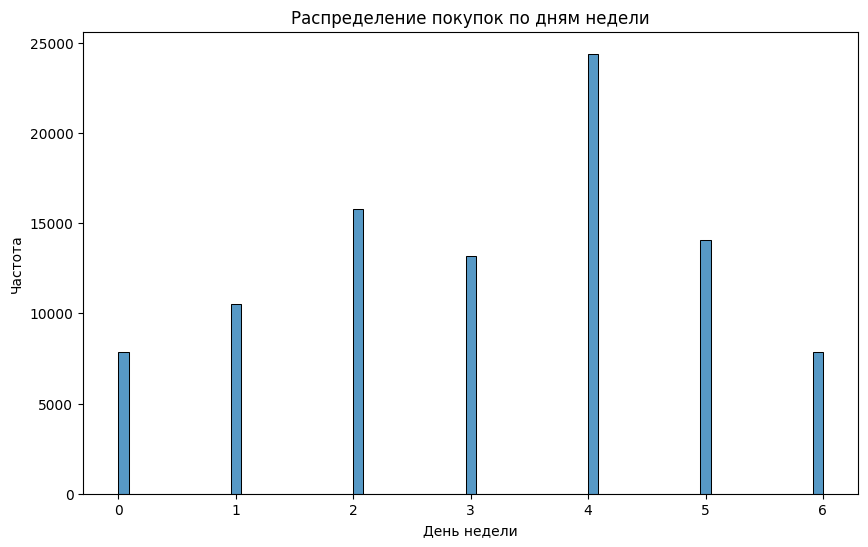

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(df_grouped['day_of_week'])
plt.title('Распределение покупок по дням недели')
plt.xlabel('День недели')
plt.ylabel('Частота')
plt.show()

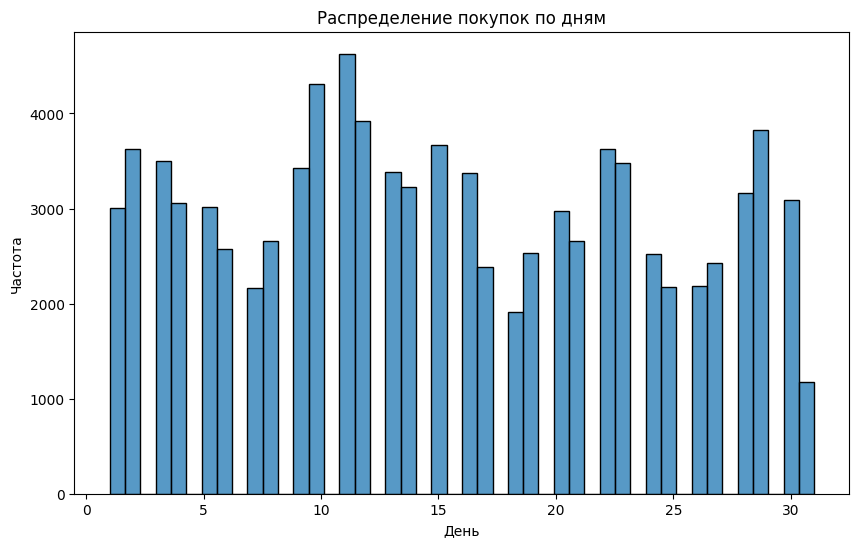

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(df_grouped['day'])
plt.title('Распределение покупок по дням')
plt.xlabel('День')
plt.ylabel('Частота')
plt.show()

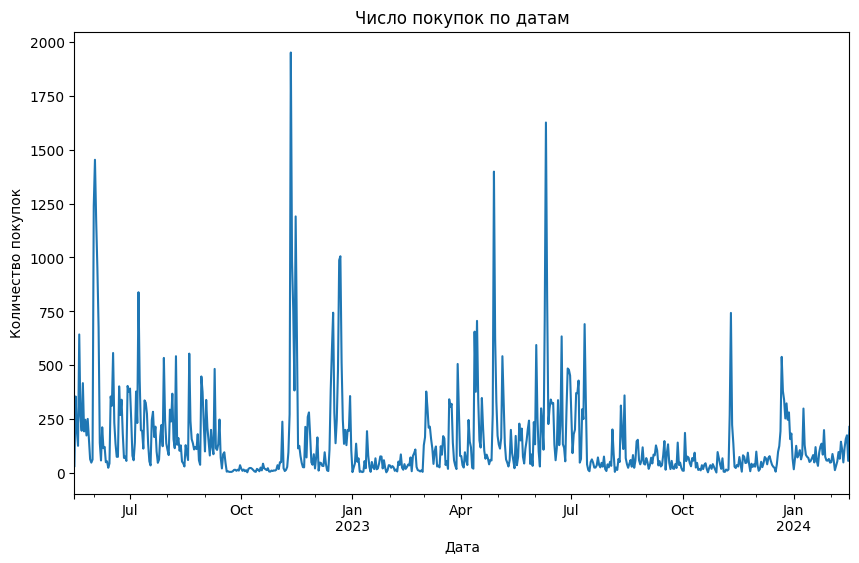

In [37]:
# Линейный график для просмотра тренда продаж
df_grouped.groupby('date').size().plot(figsize=(10,6))
plt.title('Число покупок по датам')
plt.xlabel('Дата')
plt.ylabel('Количество покупок')
plt.show()

**Вывод:**

В датафрейме `df_purchases` изменили тип данных у двух столбцов.\
Пропуски отсутствуют.\
73020 явных дубликата. Решили их оставить так как нельзя определить дубликаты это или человек зашел повторно по ссылке в этот же день и заказал ещё один такой товар.\
В основном покупатели заказывают до 5 товаров стоимостью до 3500 рублей.\
Были удалены пользователи без категорий товаров и определена целевая категория.\
Сгруппированы данные по `message_id`, `client_id`,`category`, `date` и посчитана сумма `quantity`, `price`.\
Добавлены новые признаки `year`, `month`, `day`, `day_of_week`.\
Чаше всего покупают в июне месяце.\
День недели с большей частотой покупок пятница.\
В 10 числах месяца больше всего покупок. Видимо у людей приходит зарплата.\
По тренду видно что чаще покупают в июне, ноябре и декабре. В ноябре проходит черная пятница, а в декабре люди готовятся к новому году

#### Датафрейм df_target

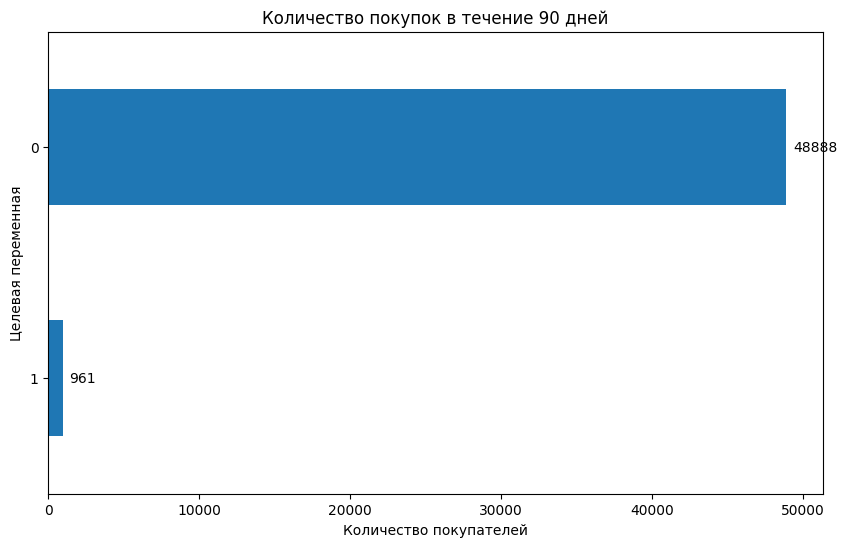

In [38]:
print_barh(df_target['target'])
plt.title('Количество покупок в течение 90 дней')
plt.xlabel('Количество покупателей')
plt.ylabel('Целевая переменная')
plt.show()

Наблюдается явный дисбаланс класса

In [39]:
print(f"Количество уникальных клиентов: {df_target['client_id'].nunique()}")

Количество уникальных клиентов: 49849


**Вывод:**

Наблюдается явный дисбаланс класса. Большая часть покупателей не совершила покупку.\
Количество уникальных клиентов совпадает с датафреймом `df_purchases`

#### Датафрейм df_messages

In [40]:
df_messages.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


In [41]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   bulk_campaign_id  int64 
 1   client_id         int64 
 2   message_id        object
 3   event             object
 4   channel           object
 5   date              object
 6   created_at        object
dtypes: int64(2), object(5)
memory usage: 680.4+ MB


In [42]:
# Переведем 2 столбца в формат даты
df_messages['date'] = pd.to_datetime(df_messages['date']).dt.floor('D')
df_messages['created_at'] = pd.to_datetime(df_messages['created_at']).dt.floor('S')

In [43]:
#Проверим наличие явных дубликатов
df_messages.duplicated().sum()

48610

In [44]:
df_messages.drop_duplicates(inplace=True)
#Проверим наличие явных дубликатов
df_messages.duplicated().sum()

0

In [45]:
# Выведем информацию о наличии пропусков
df_messages.isna().sum()

bulk_campaign_id    0
client_id           0
message_id          0
event               0
channel             0
date                0
created_at          0
dtype: int64

In [46]:
df_messages['event'].unique()

array(['open', 'click', 'purchase', 'send', 'unsubscribe', 'hbq_spam',
       'hard_bounce', 'subscribe', 'soft_bounce', 'complain', 'close'],
      dtype=object)

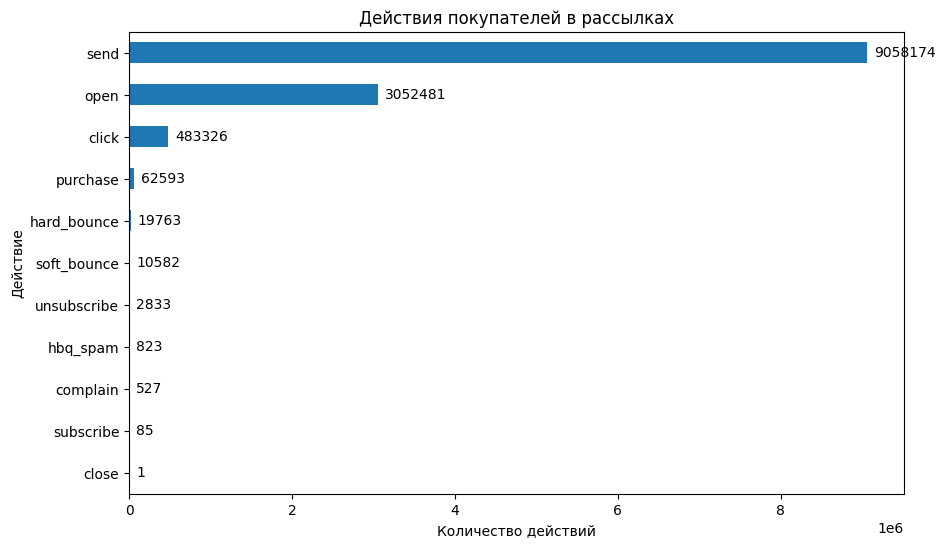

In [47]:
print_barh(df_messages['event'])
plt.title('Действия покупателей в рассылках')
plt.xlabel('Количество действий')
plt.ylabel('Действие')
plt.show()

In [48]:
df_messages['channel'].unique()

array(['email', 'mobile_push'], dtype=object)

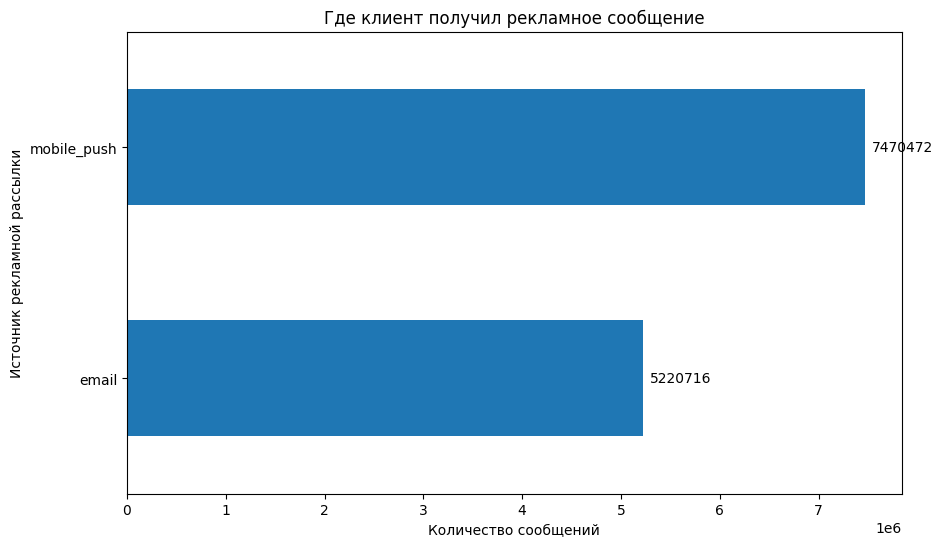

In [49]:
print_barh(df_messages['channel'])
plt.title('Где клиент получил рекламное сообщение')
plt.xlabel('Количество сообщений')
plt.ylabel('Источник рекламной рассылки')
plt.show()

In [50]:
agg_df = df_messages.groupby(['message_id', 'client_id']).agg(
    event_count=('event', 'size'),
    channel=('channel', 'first')
).reset_index()

In [51]:
agg_df.head()

,message_id,client_id,event_count,channel
0,1515915625468060902-10022-63e5ededd911f,1515915625468060902,1,email
1,1515915625468060902-10218-63ef56ed94656,1515915625468060902,1,email
2,1515915625468060902-10289-63f35a8a9ff35,1515915625468060902,1,email
3,1515915625468060902-10373-63f5cbba42484,1515915625468060902,1,email
4,1515915625468060902-10507-63ff04f701e74,1515915625468060902,1,email


In [52]:
agg_df['event_count'].unique()

array([   1,    2,    3,    4,   11,    7,    6,    5,    8,   16,   10,
         13,    9,   14,   20,   12,   17,   93,   18,   23,   29,  102,
         55,   22,   27,   15,   19,   21,   25,   45,   57,  103,   26,
         28,  147,   66,   24,   62,   32,   42,   30,   38,   52,   35,
         72,   37,   31,   33,   39,  249,   74, 1427,   40,   77,  438,
         36,  141,  214,   70,  182,   34,   78,   46,   50,   56,   92,
         49,   47,   43,  135,   63,  286,   61,   53], dtype=int64)

**Вывод:**

В датафрейме `df_messages` изменили тип данных у двух столбцов.\
Пропуски отсутствуют.\
48610 явных дубликата. Решили удалить их так как в столбце `created_at` дата с точностью до секунды и повтор это явный дубликат.\
30% отправленных сообщений открывается и 5% сообщений приводят к покупке.\
Рассылка проводилась в основном через пуш уведомления.\
Сгруппировали данные по `message_id`, `client_id` и посчитали сколько действий совершил пользователь и из какого канала пришла рекламная рассылка.\

In [53]:
# Объединение
result_df = pd.merge(
    df_grouped,
    agg_df,
    on=['message_id', 'client_id'],
    how='left'
)

In [54]:
result_df.head(10)

,message_id,client_id,category,date,quantity,price,year,month,day,day_of_week,event_count,channel
0,1515915625468060902-4617-6290657dac196,1515915625468060902,1599,2022-05-27,1,1299,2022,5,27,4,11.00,email
1,1515915625468060902-4617-6290657dac196,1515915625468060902,420,2022-05-27,2,3998,2022,5,27,4,11.00,email
2,1515915625468060902-4617-6290657dac196,1515915625468060902,422,2022-05-27,1,299,2022,5,27,4,11.00,email
3,1515915625468060902-4617-6290657dac196,1515915625468060902,432,2022-05-27,1,999,2022,5,27,4,11.00,email
4,1515915625468060902-4617-6290657dac196,1515915625468060902,458,2022-05-27,2,398,2022,5,27,4,11.00,email
5,1515915625468061003-9148-63b54b04855a4,1515915625468061003,615,2023-01-04,7,16235,2023,1,4,2,4.00,email
6,1515915625468061099-4439-62834141aa538,1515915625468061099,424,2022-05-17,1,299,2022,5,17,1,NaN,NaN
7,1515915625468061100-14623-65c5c55eeb9e0,1515915625468061100,5717,2024-02-10,2,2098,2024,2,10,5,4.00,mobile_push
8,1515915625468061170-11144-641ad2cda77a2,1515915625468061170,441,2023-03-26,2,5398,2023,3,26,6,7.00,email
9,1515915625468061170-11208-6423f082d2fcb,1515915625468061170,420,2023-03-29,12,25192,2023,3,29,2,4.00,email


In [55]:
# Заполняем пропущенные значения, если они есть
result_df['event_count'] = result_df['event_count'].fillna(0)
result_df['channel'] = result_df['channel'].fillna('no_ads')

In [56]:
result_df = result_df.drop('message_id', axis=1)

In [57]:
# Находим максимальную дату во всем датафрейме
max_date = result_df['date'].max()

# Группируем по client_id и находим даты первой и последней покупки
client_purchase_dates = result_df.groupby('client_id')['date'].agg(['min', 'max']).reset_index()
client_purchase_dates.columns = ['client_id', 'first_purchase_date', 'last_purchase_date']

# Вычисляем количество дней от этих дат до максимальной даты
client_purchase_dates['days_since_first_purchase'] = (max_date - client_purchase_dates['first_purchase_date']).dt.days
client_purchase_dates['days_since_last_purchase'] = (max_date - client_purchase_dates['last_purchase_date']).dt.days

# Объединяем с исходным датафреймом
result_df = pd.merge(
    result_df,
    client_purchase_dates[['client_id', 'days_since_first_purchase', 'days_since_last_purchase']],
    on='client_id',
    how='left'
)

In [58]:
# Вычисляем дату 90 дней назад от максимальной даты
date_90_days_ago = max_date - pd.Timedelta(days=90)

# Группируем по client_id и проверяем, есть ли покупки за последние 90 дней
purchase_last_90_days = result_df.groupby('client_id')['date'].apply(
    lambda x: 1 if (x.max() >= date_90_days_ago) else 0
).reset_index()
purchase_last_90_days.columns = ['client_id', 'purchase_last_90_days']

# Объединяем с исходным датафреймом
result_df = pd.merge(
    result_df,
    purchase_last_90_days,
    on='client_id',
    how='left'
)

In [59]:
result_df.head(10)

,client_id,category,date,quantity,price,year,month,day,day_of_week,event_count,channel,days_since_first_purchase,days_since_last_purchase,purchase_last_90_days
0,1515915625468060902,1599,2022-05-27,1,1299,2022,5,27,4,11.00,email,630,630,0
1,1515915625468060902,420,2022-05-27,2,3998,2022,5,27,4,11.00,email,630,630,0
2,1515915625468060902,422,2022-05-27,1,299,2022,5,27,4,11.00,email,630,630,0
3,1515915625468060902,432,2022-05-27,1,999,2022,5,27,4,11.00,email,630,630,0
4,1515915625468060902,458,2022-05-27,2,398,2022,5,27,4,11.00,email,630,630,0
5,1515915625468061003,615,2023-01-04,7,16235,2023,1,4,2,4.00,email,408,408,0
6,1515915625468061099,424,2022-05-17,1,299,2022,5,17,1,0.00,no_ads,640,640,0
7,1515915625468061100,5717,2024-02-10,2,2098,2024,2,10,5,4.00,mobile_push,6,6,1
8,1515915625468061170,441,2023-03-26,2,5398,2023,3,26,6,7.00,email,327,244,0
9,1515915625468061170,420,2023-03-29,12,25192,2023,3,29,2,4.00,email,327,244,0


In [60]:
# Выведем информацию о наличии пропусков
result_df.isna().sum()

client_id                    0
category                     0
date                         0
quantity                     0
price                        0
year                         0
month                        0
day                          0
day_of_week                  0
event_count                  0
channel                      0
days_since_first_purchase    0
days_since_last_purchase     0
purchase_last_90_days        0
dtype: int64

In [61]:
final_df = pd.merge(
    result_df,
    df_target,
    on=['client_id'],
    how='left'
)

In [62]:
final_df.head()

,client_id,category,date,quantity,price,year,month,day,day_of_week,event_count,channel,days_since_first_purchase,days_since_last_purchase,purchase_last_90_days,target
0,1515915625468060902,1599,2022-05-27,1,1299,2022,5,27,4,11.00,email,630,630,0,0
1,1515915625468060902,420,2022-05-27,2,3998,2022,5,27,4,11.00,email,630,630,0,0
2,1515915625468060902,422,2022-05-27,1,299,2022,5,27,4,11.00,email,630,630,0,0
3,1515915625468060902,432,2022-05-27,1,999,2022,5,27,4,11.00,email,630,630,0,0
4,1515915625468060902,458,2022-05-27,2,398,2022,5,27,4,11.00,email,630,630,0,0


In [63]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93646 entries, 0 to 93645
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   client_id                  93646 non-null  int64         
 1   category                   93646 non-null  object        
 2   date                       93646 non-null  datetime64[ns]
 3   quantity                   93646 non-null  int64         
 4   price                      93646 non-null  int32         
 5   year                       93646 non-null  int64         
 6   month                      93646 non-null  int64         
 7   day                        93646 non-null  int64         
 8   day_of_week                93646 non-null  int64         
 9   event_count                93646 non-null  float64       
 10  channel                    93646 non-null  object        
 11  days_since_first_purchase  93646 non-null  int64         
 12  days

In [64]:
final_df = final_df.drop(columns = ['client_id', 'date'], axis=1)

In [65]:
final_df['event_count'] = final_df['event_count'].astype(int)

In [66]:
final_df['purchase_last_90_days'] = final_df['purchase_last_90_days'].astype('category')

**Вывод:**

Объединили 2 датафрейма по `message_id`, `client_id`. Заполнили пропущенные значения.\
Удалили `message_id` он не нужен для моделей.\
Добавили 2 новых признака. Нашли первую дату покупки покупателя и последнюю.\
Добавили ещё один признак. Совершал ли покупатель за последние 90 дней покупку или нет.\
Добавили целевую переменную в объедененный датафрейм.\
Поменяли тип данных в столбцах и удалили не информативные столбцы для модели

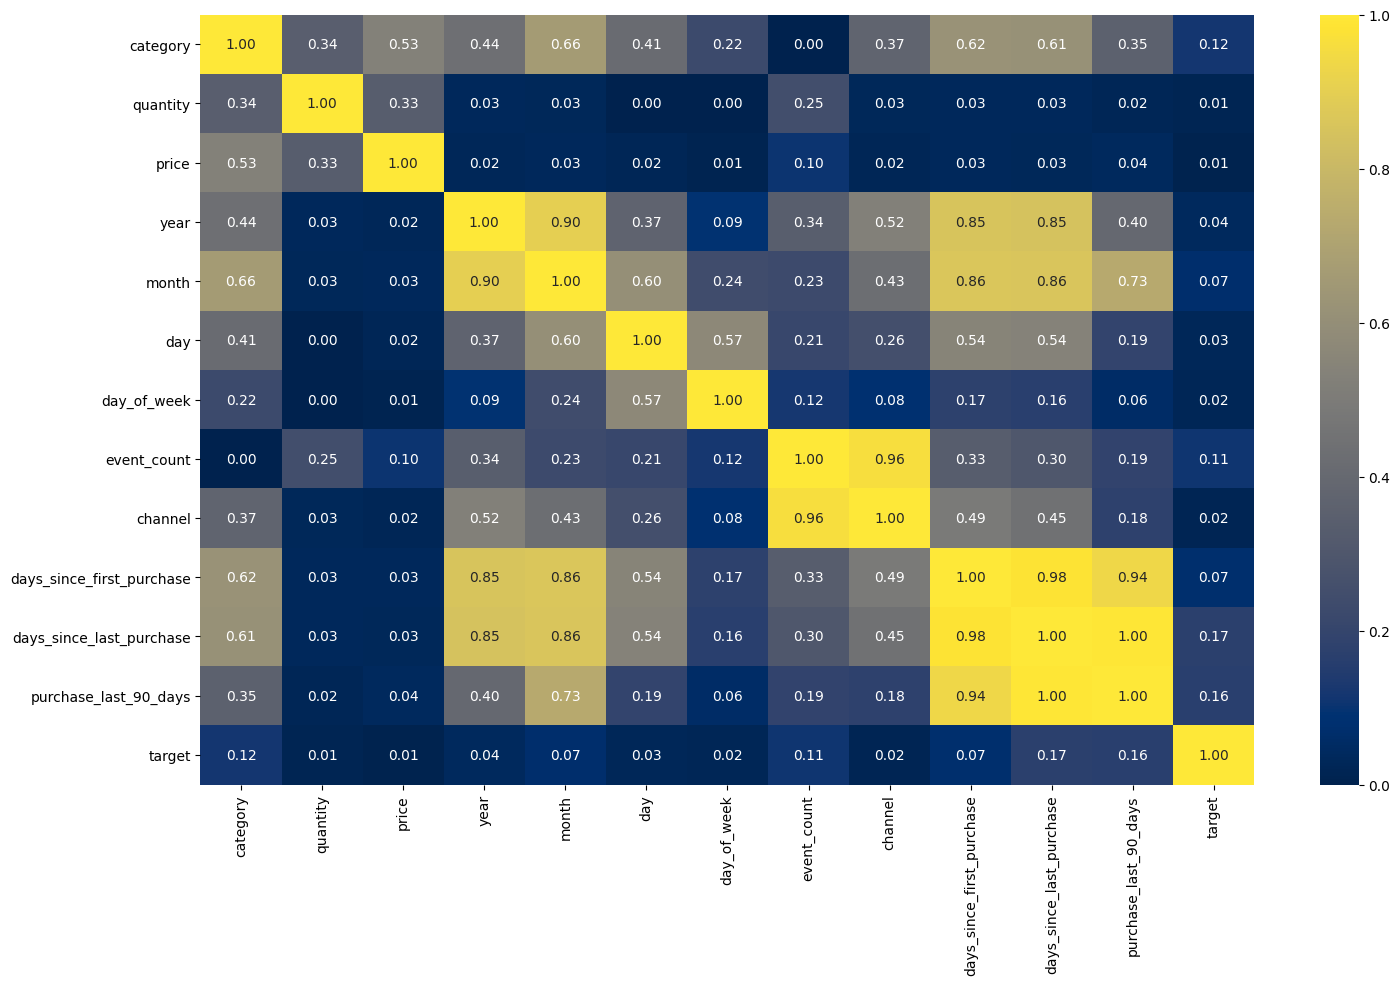

In [67]:
# Коэффициенты корреляции Фи
interval_cols = ['price', 
                 'quantity', 
                 'days_since_first_purchase',
                 'days_since_last_purchase'
                ]
plt.figure(figsize=(17, 10))
sns.heatmap(
    final_df.phik_matrix(verbose=False, interval_cols=interval_cols),
    annot=True,
    fmt='.2f',
    cmap='cividis'
);

Мультиколениарность наблюдается у признаков `days_since_first_purchase` и `purchase_last_90_days` и `days_since_last_purchase`.\
Заменим признаки `days_since_first_purchase` и `days_since_last_purchase` на количество дней от первой покупки до последней и назовем признак `days_since_purchase`

In [68]:
final_df['days_since_purchase']	= final_df['days_since_first_purchase'] - final_df['days_since_last_purchase']
final_df = final_df.drop(columns = ['days_since_first_purchase', 'days_since_last_purchase'], axis=1)

Мультиколениарность наблюдается у признаков `event_count` и `channel`.\
Объеденим их в один признак `chanel_event_count`

In [69]:
final_df['chanel_event_count']	= final_df['event_count'].astype(str) + '_' + final_df['channel']
final_df = final_df.drop(columns = ['event_count', 'channel'], axis=1)

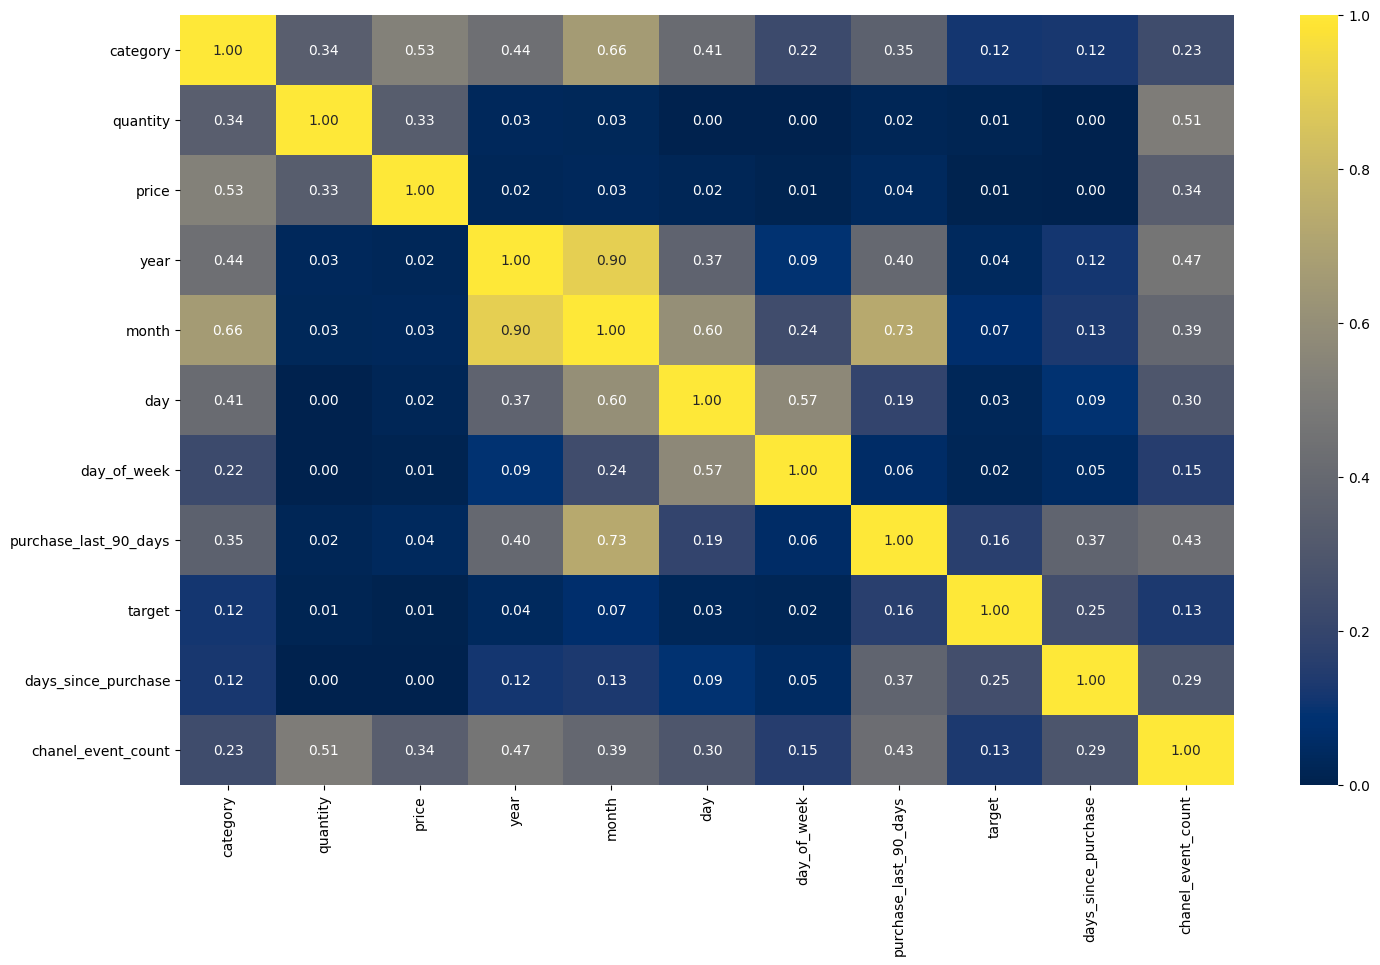

In [70]:
# Коэффициенты корреляции Фи
interval_cols = ['price', 
                 'quantity',
                 'days_since_purchase'
                ]
plt.figure(figsize=(17, 10))
sns.heatmap(
    final_df.phik_matrix(verbose=False, interval_cols=interval_cols),
    annot=True,
    fmt='.2f',
    cmap='cividis'
);

In [71]:
final_df.head()

,category,quantity,price,year,month,day,day_of_week,purchase_last_90_days,target,days_since_purchase,chanel_event_count
0,1599,1,1299,2022,5,27,4,0,0,0,11_email
1,420,2,3998,2022,5,27,4,0,0,0,11_email
2,422,1,299,2022,5,27,4,0,0,0,11_email
3,432,1,999,2022,5,27,4,0,0,0,11_email
4,458,2,398,2022,5,27,4,0,0,0,11_email


### Обучение моделей

Выберем следующие классификаторы для обучения модели:
- DecisionTreeClassifier
- CatBoostClassifier
- KNeighborsClassifieressor

В качестве метрики для всех моделей будем использовать ROC_AUC

In [72]:
def optimize(df):
    # Типы, которые будем проверять на оптимизацию
    
    numerics = ['int16', 'int32', 'int64']
    
    # Размер занимаемой памяти до оптимизации (в Мб)
    before = df.memory_usage().sum() / 1024**2
    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
    # Размер занимаемой памяти после оптимизации (в Мб)
    after = df.memory_usage().sum() / 1024**2
    print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                            .format(before, after, 100 * (before - after) / before))
    return df

In [73]:
# Оптимизируем финальный датафрейм
optimize(final_df)

Размер использования памяти: до  7.59 Mb - после  3.39 Mb (55.3%)


,category,quantity,price,year,month,day,day_of_week,purchase_last_90_days,target,days_since_purchase,chanel_event_count
0,1599,1,1299,2022,5,27,4,0,0,0,11_email
1,420,2,3998,2022,5,27,4,0,0,0,11_email
2,422,1,299,2022,5,27,4,0,0,0,11_email
3,432,1,999,2022,5,27,4,0,0,0,11_email
4,458,2,398,2022,5,27,4,0,0,0,11_email
...,...,...,...,...,...,...,...,...,...,...,...
93641,661,2,2828,2024,2,13,1,1,0,0,3_mobile_push
93642,663,4,7969,2024,2,13,1,1,0,0,3_mobile_push
93643,443,4,1676,2024,2,14,2,1,0,0,5_mobile_push
93644,1194,2,2998,2024,2,16,4,1,0,0,0_no_ads


In [74]:
# Сохранение признаков
X = final_df.drop('target', axis=1)
y = final_df['target']

In [75]:
# Разделим признаки на категорийные и численные
cat_column = ['chanel_event_count',
              'year',
              'month',
              'day',
              'day_of_week',
              'purchase_last_90_days']
num_column = ['category',
              'quantity',
              'price',
              'days_since_purchase'
             ]

In [76]:
# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE, 
    test_size=TEST_SIZE,
    stratify=y
)

In [77]:
# Создадим пайплайн для кодирования
ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
]) 

data_preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, cat_column),
    ('num', StandardScaler(), num_column)
], remainder='passthrough') 

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


In [78]:
# Создаем StratifiedKFold с перемешиванием и фиксированным random_state
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Определяем параметры для каждой модели

param_distributions_tree = {
    'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
    'models__max_depth': list(range(2, 20)),
    'models__max_features': list(range(2, 20)),
    'models__min_samples_split': list(range(2, 20)),
    'models__min_samples_leaf': list(range(2, 20))
}

param_distributions_catboost = {
    'models': [CatBoostClassifier(random_seed=RANDOM_STATE, verbose=0)],
    'models__iterations': [200, 400],
    'models__learning_rate': [0.1, 0.3],
    'models__depth': [4, 6, 8]
}

param_distributions_knn = {
    'models': [KNeighborsClassifier()],
    'models__n_neighbors' : list(range(2, 20)),
    'models__weights': ['uniform', 'distance'],

}

# Создаем список моделей для поиска
models_to_search = [
    ('DecisionTree', param_distributions_tree, 20),
    ('CatBoost', param_distributions_catboost, 5),
    ('KNN', param_distributions_knn, 5)
]

# Словари для хранения результатов
results = {}
training_times = {}
best_models = {}

print("НАЧАЛО ПОИСКА ГИПЕРПАРАМЕТРОВ ДЛЯ МОДЕЛЕЙ")

# Проходим по всем моделям
for model_name, param_distributions, n_iter in models_to_search:
    print(f"\n{'='*60}")
    print(f"МОДЕЛЬ: {model_name}")
    print(f"ИТЕРАЦИЙ: {n_iter}")
    print(f"{'='*60}")
    
    start_time = time.time()
    
    try:
        randomized_search = RandomizedSearchCV(
            estimator=pipe_final, 
            param_distributions=param_distributions, 
            scoring='roc_auc', 
            random_state=RANDOM_STATE,
            n_jobs=-1,
            n_iter=n_iter,
            cv=skf, 
            error_score="raise",
            verbose=1
        )
        
        print(f"Запуск кросс-валидации для {model_name}...")
        randomized_search.fit(X_train, y_train)
        
        end_time = time.time()
        training_time = end_time - start_time
        
        # Сохраняем результаты
        results[model_name] = randomized_search
        training_times[model_name] = training_time
        best_models[model_name] = randomized_search.best_estimator_
        
        # Выводим статистику кросс-валидации
        print(f"\n{model_name} обучена успешно!")
        print(f"Время обучения: {training_time:.2f} сек")
        print(f"Лучшая ROC_AUC (CV): {randomized_search.best_score_:.4f}")
        print(f"Лучшие параметры: {randomized_search.best_params_}")
        
        # Дополнительная информация о кросс-валидации
        cv_results = randomized_search.cv_results_
        print(f"Диапазон ROC_AUC (CV): {cv_results['mean_test_score'].min():.4f} - {cv_results['mean_test_score'].max():.4f}")
        
    except Exception as e:
        end_time = time.time()
        training_time = end_time - start_time
        print(f"Ошибка при обучении {model_name}: {e}")
        print(f"Прошло времени: {training_time:.2f} сек")
        training_times[model_name] = training_time

print("ПОИСК ГИПЕРПАРАМЕТРОВ МОДЕЛЕЙ ЗАВЕРШЕН")

НАЧАЛО ПОИСКА ГИПЕРПАРАМЕТРОВ ДЛЯ МОДЕЛЕЙ

МОДЕЛЬ: DecisionTree
ИТЕРАЦИЙ: 20
Запуск кросс-валидации для DecisionTree...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

DecisionTree обучена успешно!
Время обучения: 37.40 сек
Лучшая ROC_AUC (CV): 0.7148
Лучшие параметры: {'models__min_samples_split': 16, 'models__min_samples_leaf': 2, 'models__max_features': 16, 'models__max_depth': 19, 'models': DecisionTreeClassifier(random_state=42)}
Диапазон ROC_AUC (CV): 0.5130 - 0.7148

МОДЕЛЬ: CatBoost
ИТЕРАЦИЙ: 5
Запуск кросс-валидации для CatBoost...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

CatBoost обучена успешно!
Время обучения: 212.83 сек
Лучшая ROC_AUC (CV): 0.8036
Лучшие параметры: {'models__learning_rate': 0.1, 'models__iterations': 400, 'models__depth': 8, 'models': <catboost.core.CatBoostClassifier object at 0x00000108015CB490>}
Диапазон ROC_AUC (CV): 0.7740 - 0.8036

МОДЕЛЬ: KNN
ИТЕРАЦИЙ: 5
Запуск кросс-валидации для KNN...
Fitting 5 folds for each of

In [79]:
# Выбор лучшей модели по качеству кросс-валидации

print("ВЫБОР ЛУЧШЕЙ МОДЕЛИ ПО КАЧЕСТВУ КРОСС-ВАЛИДАЦИИ")


# Создаем DataFrame для сравнения моделей
comparison_data = []
for model_name, _, _ in models_to_search:
    if model_name in results:
        search = results[model_name]
        comparison_data.append({
            'Модель': model_name,
            'ROC_AUC_CV': search.best_score_,
            'Лучшие_параметры': search.best_params_,
            'Время_обучения_сек': training_times[model_name]
        })

if comparison_data:
    # Создаем DataFrame и сортируем по качеству (RMSE)
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('ROC_AUC_CV', ascending=False)
    
    print("Рейтинг моделей по качеству кросс-валидации:")
    print(comparison_df[['Модель', 'ROC_AUC_CV', 'Время_обучения_сек']].to_string(index=False))
    
    # Выбираем лучшую модель
    best_model_name = comparison_df.iloc[0]['Модель']
    best_search = results[best_model_name]
    best_model = best_models[best_model_name]
    
    print(f"\nЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
    print(f"Лучший roc_auc на кросс-валидации: {best_search.best_score_:.4f}")
    print(f"Параметры лучшей модели: {best_search.best_params_}")
    print(f"Время обучения: {training_times[best_model_name]:.2f} сек")
else:
    print("Ни одна модель не была успешно обучена")
    
print("ВЫБОР МОДЕЛИ ЗАВЕРШЕН")


ВЫБОР ЛУЧШЕЙ МОДЕЛИ ПО КАЧЕСТВУ КРОСС-ВАЛИДАЦИИ
Рейтинг моделей по качеству кросс-валидации:
      Модель  ROC_AUC_CV  Время_обучения_сек
    CatBoost        0.80              212.83
         KNN        0.77              173.09
DecisionTree        0.71               37.40

ЛУЧШАЯ МОДЕЛЬ: CatBoost
Лучший roc_auc на кросс-валидации: 0.8036
Параметры лучшей модели: {'models__learning_rate': 0.1, 'models__iterations': 400, 'models__depth': 8, 'models': <catboost.core.CatBoostClassifier object at 0x00000108015CB490>}
Время обучения: 212.83 сек
ВЫБОР МОДЕЛИ ЗАВЕРШЕН


In [80]:
y_test_pred = randomized_search.predict(X_test)
y_test_proba = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {round(roc_auc_score(y_test, y_test_proba[:,1]), 4)}')

Метрика ROC-AUC на тестовой выборке: 0.7806


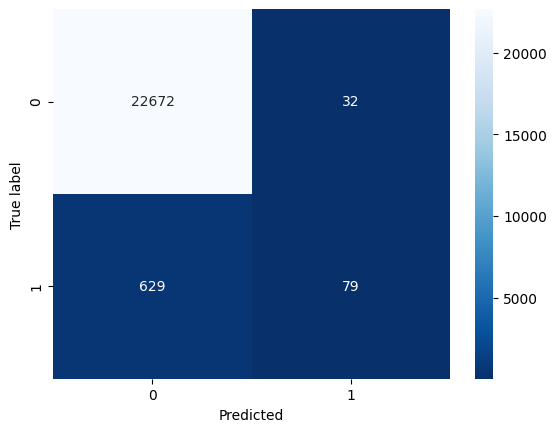

In [81]:
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted'); 

**Вывод:**

Оптимизировали размер финального датафрейма.\
Создали пайплайн для поиска гиперпараметров моделей RandomizedSearchCV.\
Все модели показали результат ROC_AUC выше 0.7\
Лучшей моделью стала модель **СatBoost** со значением ROC_AUC=0.8\
Параметры лучшей модели: {'models__learning_rate': 0.1, 'models__iterations': 400, 'models__depth': 8, 'models': <catboost.core.CatBoostClassifier object at 0x000001F080D3D850>}\
Метрика ROC-AUC на тестовой выборке: 0.78\
confusion_matrix Показывает что модель отлично справляется определять покупателей которые не совершат покупку в течении 90 дней и плохо справляется с предсказанием покупателей которые совершат покупку в течении 90 дней.

### Влияние признаков модели

In [82]:
preprocessor_best = best_search.best_estimator_.named_steps['preprocessor']

# Преобразуем данные для анализа признаков
X_train_shape = preprocessor_best.fit_transform(X_train)
X_test_shape = preprocessor_best.transform(X_test)
feature_names = preprocessor_best.get_feature_names_out()

In [83]:
best_model = best_search.best_estimator_.named_steps['models']
best_model

In [84]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_shape)

In [85]:
# Создаем Explanation объект
explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=X_test_shape,
    feature_names=feature_names
)

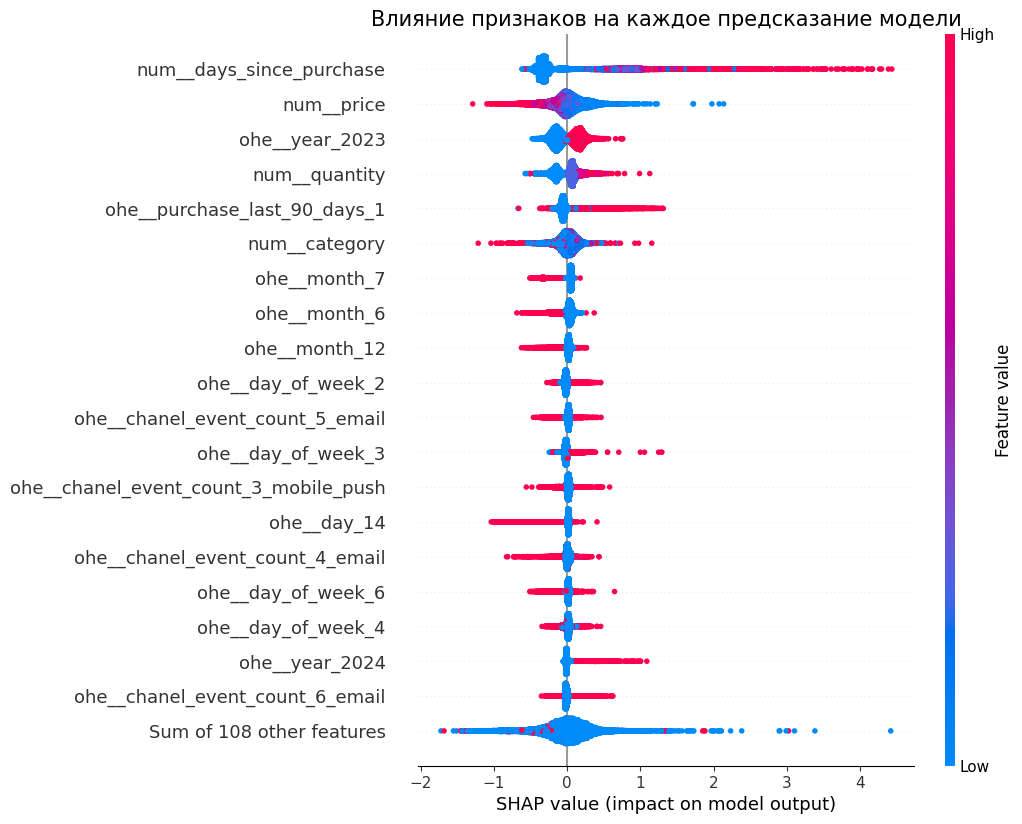

<Figure size 640x480 with 0 Axes>

In [86]:
plt.figure(figsize=(12, 8))
plt.title('Влияние признаков на каждое предсказание модели', size=15)
shap.plots.beeswarm(explanation, max_display=20)
plt.tight_layout()
plt.show()

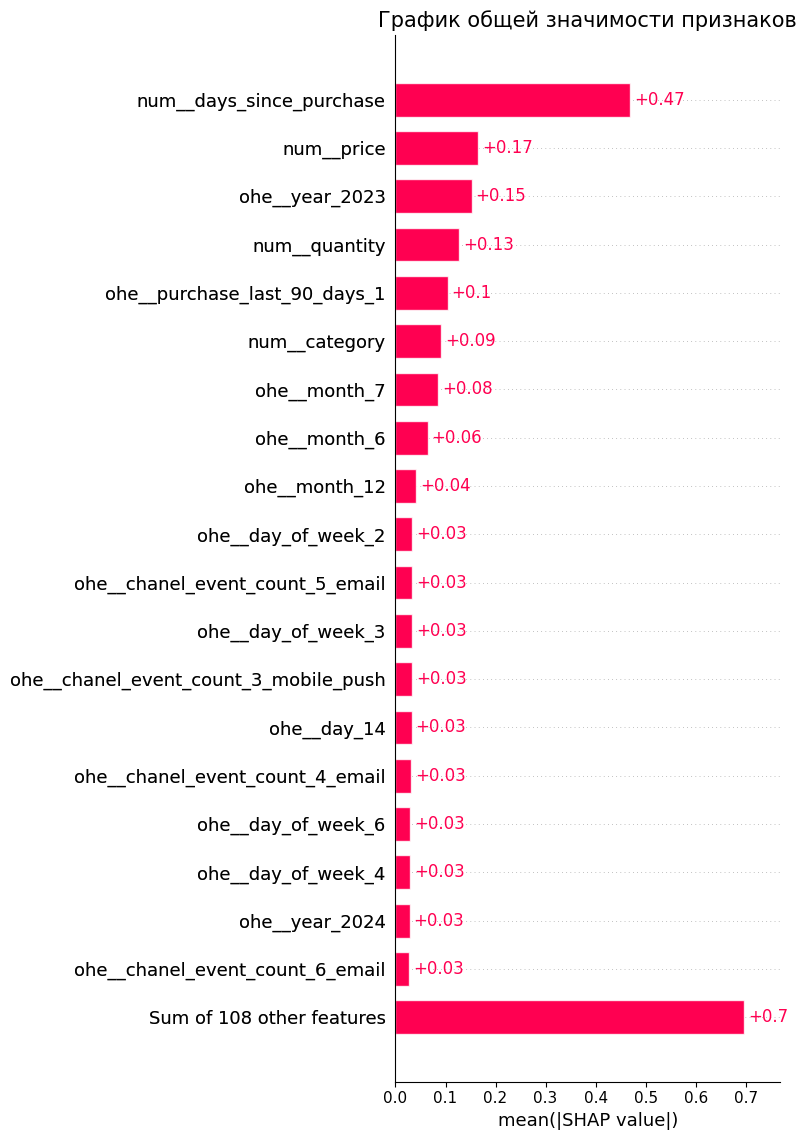

In [87]:
plt.figure(figsize=(12, 8))
shap.plots.bar(explanation, max_display=20, show=False)
plt.title('График общей значимости признаков', size=15)
plt.tight_layout()
plt.show()

**Вывод:**

Больше всего на предсказание модели влияют признаки:

- Разница в днях между первой и последней покупкой
- Стоимость товара
- Год заказа товара
- Количество единиц товара

**Общий вывод:**

Датафреймы загружены.

В датафрейме `df_purchases` изменили тип данных у двух столбцов.\
Пропуски отсутствуют.\
73020 явных дубликата. Решили их оставить так как нельзя определить дубликаты это или человек зашел повторно по ссылке в этот же день и заказал ещё один такой товар.\
В основном покупатели заказывают до 5 товаров стоимостью до 3500 рублей.\
Были удалены пользователи без категорий товаров и определена целевая категория.\
Сгруппированы данные по `message_id`, `client_id`,`category`, `date` и посчитана сумма `quantity`, `price`.\
Добавлены новые признаки `year`, `month`, `day`, `day_of_week`.\
Чаше всего покупают в июне месяце.\
День недели с большей частотой покупок пятница.\
В 10 числах месяца больше всего покупок. Видимо у людей приходит зарплата.\
По тренду видно что чаще покупают в июне, ноябре и декабре. В ноябре проходит черная пятница, а в декабре люди готовятся к новому году

В датафрейме `df_target` наблюдается явный дисбаланс класса. Большая часть покупателей не совершила покупку.\
Количество уникальных клиентов совпадает с датафреймом `df_purchases`

В датафрейме `df_messages` изменили тип данных у двух столбцов.\
Пропуски отсутствуют.\
48610 явных дубликата. Решили удалить их так как в столбце `created_at` дата с точностью до секунды и повтор это явный дубликат.\
30% отправленных сообщений открывается и 5% сообщений приводят к покупке.\
Рассылка проводилась в основном через пуш уведомления.\
Сгруппировали данные по `message_id`, `client_id` и посчитали сколько действий совершил пользователь и из какого канала пришла рекламная рассылка.\

Объединили 2 датафрейма по `message_id`, `client_id`. Заполнили пропущенные значения.\
Удалили `message_id` он не нужен для моделей.\
Добавили 2 новых признака. Нашли первую дату покупки покупателя и последнюю.\
Добавили ещё один признак. Совершал ли покупатель за последние 90 дней покупку или нет.\
Добавили целевую переменную в объедененный датафрейм.\
Поменяли тип данных в столбцах и удалили не информативные столбцы для модели

Мультиколениарность наблюдается у признаков `days_since_first_purchase` и `purchase_last_90_days` и `days_since_last_purchase`.\
Заменим признаки `days_since_first_purchase` и `days_since_last_purchase` на количество дней от первой покупки до последней и назовем признак `days_since_purchase`

Мультиколениарность наблюдается у признаков `event_count` и `channel`.\
Объеденим их в один признак `chanel_event_count`

Оптимизировали размер финального датафрейма.\
Создали пайплайн для поиска гиперпараметров моделей RandomizedSearchCV.\
Все модели показали результат ROC_AUC выше 0.7\
Лучшей моделью стала модель **СatBoost** со значением **ROC_AUC=0.8**\
Параметры лучшей модели: {'models__learning_rate': 0.1, 'models__iterations': 400, 'models__depth': 8, 'models': <catboost.core.CatBoostClassifier object at 0x000001F080D3D850>}\
Метрика **ROC-AUC на тестовой выборке: 0.78**\
confusion_matrix Показывает что модель отлично справляется определять покупателей которые не совершат покупку в течении 90 дней и плохо справляется с предсказанием покупателей которые совершат покупку в течении 90 дней.

Больше всего на предсказание модели влияют признаки:

- Разница в днях между первой и последней покупкой
- Стоимость товара
- Год заказа товара
- Количество единиц товара

Рекомендации для маркетинга:

- Персонализировать рекламные рассылки с учетом категории заказов покупателя.
- Обращать внимание на стоимость и количество товаров, которые ранее заказывал покупатель.
- Если покупатель долгое время не заказывал, то направить какой нибудь промокод, что бы покупатель вернулся за покупками.
- Увеличить число рекламных сообщений в период больших сезонных распрадаж, а также в предполагаемые дни зарплат у покупателя.
- Так же можно довавить рекламных сообщений в пятницу, когда покупатели после рабочей недели, часто отдыхая, проводят время за онлайн покупками